In [23]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Download and Prepare Data

In [2]:
# Load the data
try: # local
    region0 = pd.read_csv('geo_data_0.csv')
    region1 = pd.read_csv('geo_data_1.csv')
    region2 = pd.read_csv('geo_data_2.csv')
except: # from TripTen server
    region0 = pd.read_csv('/datasets/geo_data_0.csv')
    region1 = pd.read_csv('/datasets/geo_data_1.csv')
    region2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
# Assert that each df has the same columns
assert region0.columns.all() == region1.columns.all() == region2.columns.all()

# Assert there are no missing values in any of the dataframes
assert region0.isnull().sum().sum() == region1.isnull().sum().sum() == region2.isnull().sum().sum() == 0

# Assert there are no fully duplicated rows in any of the dataframes
assert region0.duplicated().sum() == region1.duplicated().sum() == region2.duplicated().sum() == 0

In [4]:
def display_duplicated_ids():
    counter = 0
    for region in [region0, region1, region2]:
        dup_cnt = region['id'].duplicated().sum()
        print(f'region {counter}, {dup_cnt} duplicated ids:')
        display(region[region['id'].duplicated(keep=False)].sort_values('id'))
        counter += 1
        
display_duplicated_ids()

region 0, 10 duplicated ids:


,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


region 1, 4 duplicated ids:


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


region 2, 4 duplicated ids:


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


### Duplicate IDS
There is a total of 18 duplicated ids between the three data tables, but each duplicated id has at least 1 different feature value from their duplicate(s). This is confirmed by the assertion that there are no fully duplicated rows in any of the tables. 

As such, these duplicated ids will be treated as unique ids. We will not bother to assign a new unique id, since the id column will be dropped for training anyway.

In [5]:
# Describe the feature data for each region to determine if scaling is necessary
for region in [region0, region1, region2]:
    display(region[['f0', 'f1', 'f2',]].describe())

,f0,f1,f2
count,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647
std,0.871832,0.504433,3.248248
min,-1.408605,-0.848218,-12.088328
25%,-0.072580,-0.200881,0.287748
50%,0.502360,0.250252,2.515969
75%,1.073581,0.700646,4.715088
max,2.362331,1.343769,16.003790


,f0,f1,f2
count,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541
std,8.965932,5.119872,1.703572
min,-31.609576,-26.358598,-0.018144
25%,-6.298551,-8.267985,1.000021
50%,1.153055,-4.813172,2.011479
75%,8.621015,-1.332816,3.999904
max,29.421755,18.734063,5.019721


,f0,f1,f2
count,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128
std,1.732045,1.730417,3.473445
min,-8.760004,-7.084020,-11.970335
25%,-1.162288,-1.174820,0.130359
50%,0.009424,-0.009482,2.484236
75%,1.158535,1.163678,4.858794
max,7.238262,7.844801,16.739402


### Need for Scaling
For each data table, there is significant variation in scale for the feature columns. Scaling the feature columns will be necessary for training on each region.

## Train and Test the Model for Each Region

In [6]:
def train_and_test(data):
    
    # Split the data into features and target
    features = data.drop(['id', 'product'], axis=1)
    target = data['product']
    
    # Split the data into training and validation sets
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)
    
    # Scale the features
    scaler = StandardScaler()
    # Train the scaler on the training features
    scaler.fit(features_train)
    # Transform the training and validation features
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)

    # Train the model
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    # Make predictions
    predictions = model.predict(features_valid)
    
    # Save predictions and correct answers to a DataFrame
    df = pd.DataFrame({'predictions': predictions, 'actual': target_valid})
    
    # Average volume of predicted reserves
    avg_pred = df['predictions'].mean()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(df['actual'], df['predictions']))
    print(f"Average volume of predicted reserves: {avg_pred}")
    print(f"RMSE: {rmse}")
    
    return df


In [51]:
print('Region 0:')
region0_results = train_and_test(region0)
print('\nRegion 1:')
region1_results = train_and_test(region1)
print('\nRegion 2:')
region2_results = train_and_test(region2);

Region 0:
Average volume of predicted reserves: 92.59256778438035
RMSE: 37.5794217150813

Region 1:
Average volume of predicted reserves: 68.728546895446
RMSE: 0.8930992867756163

Region 2:
Average volume of predicted reserves: 94.96504596800489
RMSE: 40.02970873393434


### Results

Regions 0 and 2 predicted the highest volume of predicted reserves, but also had very high RMSE values (prone to error) with values of 38 and 40 respectively. Region 1, predicted significantly lower reserves, but with a much better RMSE value of .89. This highlights the prescribed model's efficiency in predicting reserves at region 1 compared to regions 0 and 2.

## Prepare for Profit Calculation

In [52]:
# Calculate the volume of reserves sufficient for developing 200 new wells without losses.
budget = 100_000_000 # budget for 200 wells development
price_per_1k_barrel = 4_500 # revenue
number_of_wells = 200

min_reserve_volume = budget / price_per_1k_barrel / number_of_wells

print(f"Minimum average volume of reserves for development without losses: {min_reserve_volume:,f} (1K barrels)")


Minimum average volume of reserves for development without losses: 111.111111 (1K barrels)


In [9]:
# Compare the minimum reserve volume with the average volume of reserves in each region.
counter = 0
for region in [region0, region1, region2]:
    print(f"Region {counter} average volume of reserves: {region['product'].mean()}")
    counter += 1

Region 0 average volume of reserves: 92.50000000000001
Region 1 average volume of reserves: 68.82500000000002
Region 2 average volume of reserves: 95.00000000000004


In [10]:
# Compare the minimum reserve volume with the average volume of reserves for the top 200 wells in each region.
counter = 0
for region in [region0, region1, region2]:
    # Sort the region by product and take the top 200 wells
    top_200 = region.sort_values('product', ascending=False).head(200)
    print(f"Region {counter} average volume of reserves for top 200 wells: {top_200['product'].mean()}")
    counter += 1

Region 0 average volume of reserves for top 200 wells: 184.83373964536008
Region 1 average volume of reserves for top 200 wells: 137.9454077409057
Region 2 average volume of reserves for top 200 wells: 189.55147698176646


The average volume of reserves necessary for profitability per oil well is 111.1111. The average volume for region 0 and 2 is slightly shy of that number compared to region 1, which misses the mark by about half. However, when we look at the average volume of reserves for the top 200 wells in each region, each region is well above the 111 threshold. Presumably, these regions are all profitable, which speaks to the inaccuracy of predicting profitability based off of averages in this way.

## Calculate Profit

In [11]:
def profit(predictions):
    # Pick top 200 wells in terms of predicted reserves
    top_wells = predictions.sort_values('predictions', ascending=False).head(200)
    
    # Calculate profit
    profit = top_wells['actual'].sum() * price_per_1k_barrel - budget
    
    return profit

In [12]:
counter = 0
for region in [region0_results, region1_results, region2_results]:
    print(f"Region {counter} profit: {profit(region):,.2f}")
    counter += 1

Region 0 profit: 33,208,260.43
Region 1 profit: 24,150,866.97
Region 2 profit: 27,103,499.64


Without consideration for risk, each region would expected to be profitable according to this model, with region 0 promising the most profitability and region 1 promising the least. However, it is important to keep in mind the high RMSE scores for region 0 and 2. The consequences of those high RMSE scores will become clear in the next section.

## Calculate Risks and Bootstrap Profit

In [15]:
# Create random state instance
state = np.random.RandomState(12345)

In [18]:
# Bootstrap function
def bootstrap(predictions):
    values = []
    for i in range(1000):
        # Sample 500 wells with replacement
        sample = predictions.sample(n=500, replace=True, random_state=state)
        
        # Pick top 200 wells in terms of predicted reserves
        sample = sample.sort_values('predictions', ascending=False).head(200)
        
        # Calculate profit
        values.append(profit(sample))
        
    return values
        

In [21]:
# Bootstrap 1000 profit values for each region
r0_prof_dist = bootstrap(region0_results)
r1_prof_dist = bootstrap(region1_results)
r2_prof_dist = bootstrap(region2_results)

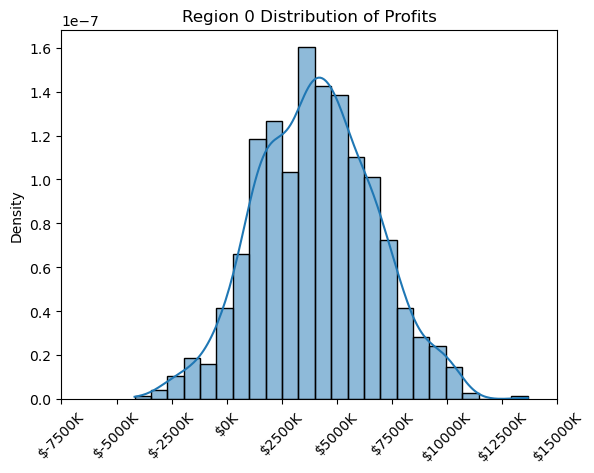

Region 0:
Average profit: $4,058,600.55
95% confidence interval: $-1,213,461.43 - $9,545,235.68
Risk of losses: 5.9%


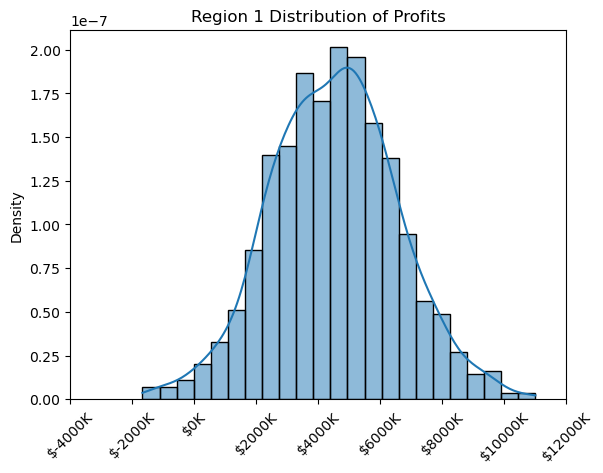

Region 1:
Average profit: $4,515,810.86
95% confidence interval: $537,757.71 - $8,630,593.55
Risk of losses: 1.4%


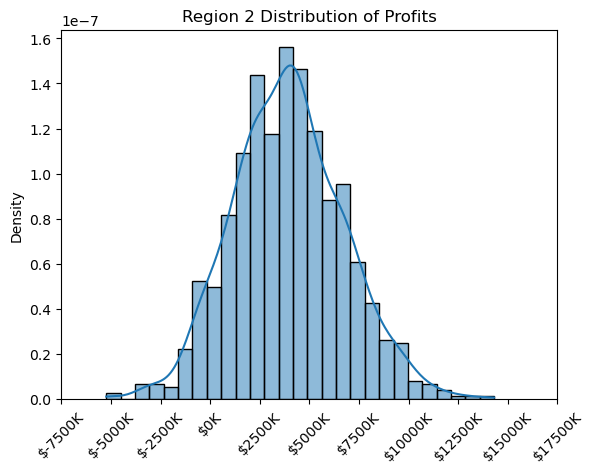

Region 2:
Average profit: $3,937,641.57
95% confidence interval: $-1,140,182.68 - $9,577,198.23
Risk of losses: 7.8%


In [53]:
# Plot the distribution of profits
counter = 0
for region in [r0_prof_dist, r1_prof_dist, r2_prof_dist]:
    # Create a new figure
    plt.figure()
    # Plot the distribution
    sns.histplot(region, stat='density', kde=True)
    
    # Set the title
    plt.title(f'Region {counter} Distribution of Profits')
    # Disable scientific notation
    plt.ticklabel_format(style='plain', axis='x')
    
    # Get current x-tick values
    values = plt.gca().get_xticks()
    # Convert values to thousands of dollars and create labels
    labels = ['$' + '{:.0f}K'.format(value/1000) for value in values]
    # Set new x-tick labels
    plt.xticks(ticks=values, labels=labels)
    # Rotate the x-tick labels
    plt.xticks(rotation=45)
    
    # Calculate the mean 95% confidence interval
    mean = np.mean(region)
    lower = np.percentile(region, 2.5)
    upper = np.percentile(region, 97.5)
    
    # Calculate the risk of losses
    risk = 0
    for value in region:
        if value < 0:
            risk += 1
    risk /= len(region)
    
    # Show the plot
    plt.show()
    
    # Print statements
    print(f"Region {counter}:")
    print(f"Average profit: ${mean:,.2f}")
    print(f"95% confidence interval: ${lower:,.2f} - ${upper:,.2f}")
    print(f"Risk of losses: {risk:.1%}")
    
    # Increment the counter
    counter += 1

## Recommendation

Based on the processes executed in this notebook, the best region for development is region 1. Not only does region 1 yield the highest profits based off the model's predictions, it does so with a higher degree of accuracy. This results in the least risk of losses (1.4%) among the three regions considered, and a confidence interval that is entirely in the green (not the case for regions 0 and 2). In short, region 1 has the highest potential for returns, and lowest potential for losses among the three regions considered.